Load libraries and read data.

In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
library(ggrepel)
library(hexbin)
library(RColorBrewer)
options(repr.plot.width=8, repr.plot.height=8)

# read switches
switches <- read_tsv("data/pancancer/candidateList_info.tumorSplit.tsv")

# read candidate info and filter-out non-functional switches
candidates <- read_tsv("data/switches/driverEvidence.tsv") %>%
    merge(switches) %>%
    subset(IsFunctional==1 & NotNoise==1 & IsModel==1) %>%
    filter(., as.logical(rowSums(.[,c("Recurrence","Affects_mutated_feature","PPI","Pannegative","DriverME")])))

# read ME with top drivers
me <- lapply(1:10, function(i){
  read_tsv(paste0("data/mutations/pannegative_mutual_exclusion.top_",i,"_drivers.txt")) %>%
    mutate(NumDrivers = i, Total = M + MS + S + N,
           M.p = M/Total, MS.p = MS/Total, 
           S.p = S/Total, N.p = N/Total,
           SwitchSamples = S + MS)
  }) %>% do.call("rbind",.)

# drivers mutations
mutatedDrivers <- read_tsv("data/mutations/driver_mutation_number.txt") %>%
    mutate(PatientNumber = unlist(lapply(strsplit(as.character(Samples),","),length)),
           Rank=as.numeric(do.call("c",by(-PatientNumber,Tumor,rank))))

# read mutual exclusion with specific drivers
me.specificDrivers <- read_tsv("data/mutations/mutual_exclusion_top_drivers.txt") %>%
    mutate(Total = M + MS + S + N, M.p = M/Total, MS.p = MS/Total,
           S.p = S/Total, N.p = N/Total)

## read specific drivers
drivers <- "data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv" %>%
    read_tsv(skip=5)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# PoTuS identification

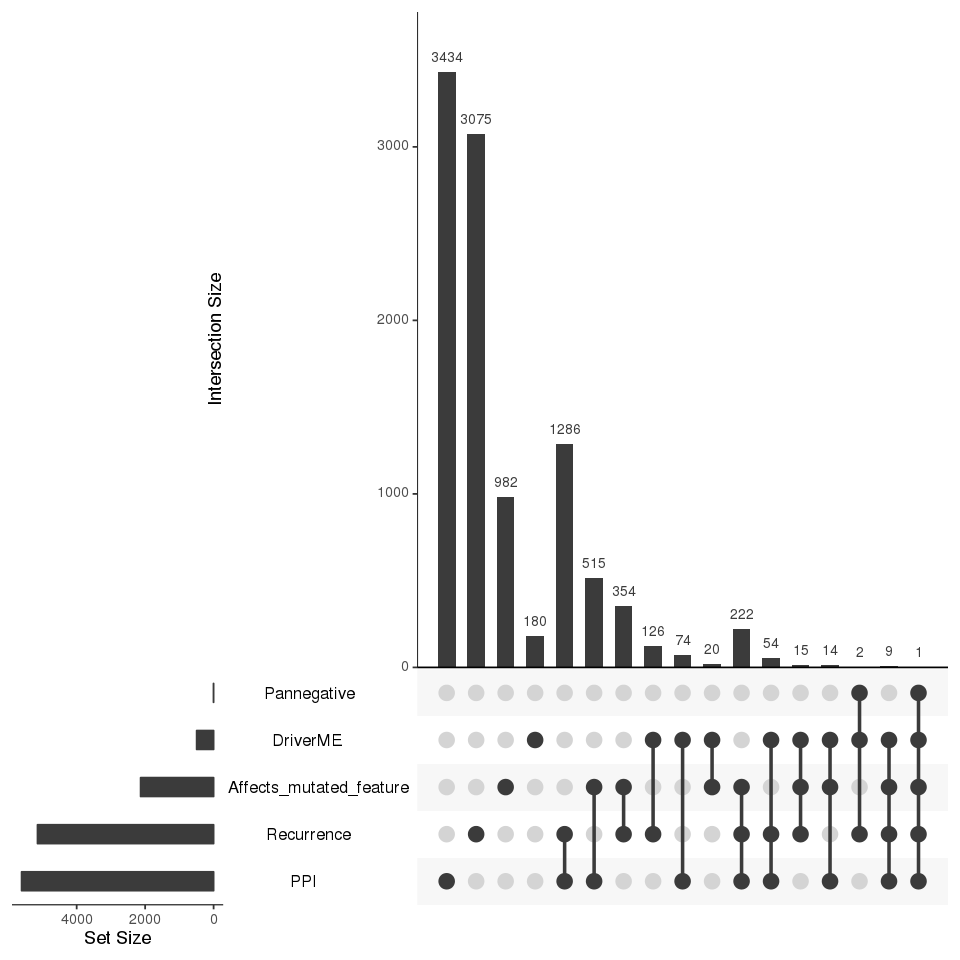

In [2]:
library(UpSetR)

candidates %>%
    select(Recurrence,Affects_mutated_feature,PPI,Pannegative,DriverME) %>%
    mutate(Pannegative = ifelse(Pannegative > 3, 1,0)) %>%
    upset

## [PPI](structural_analysis/ppi.ipynb)

## Pan-negative

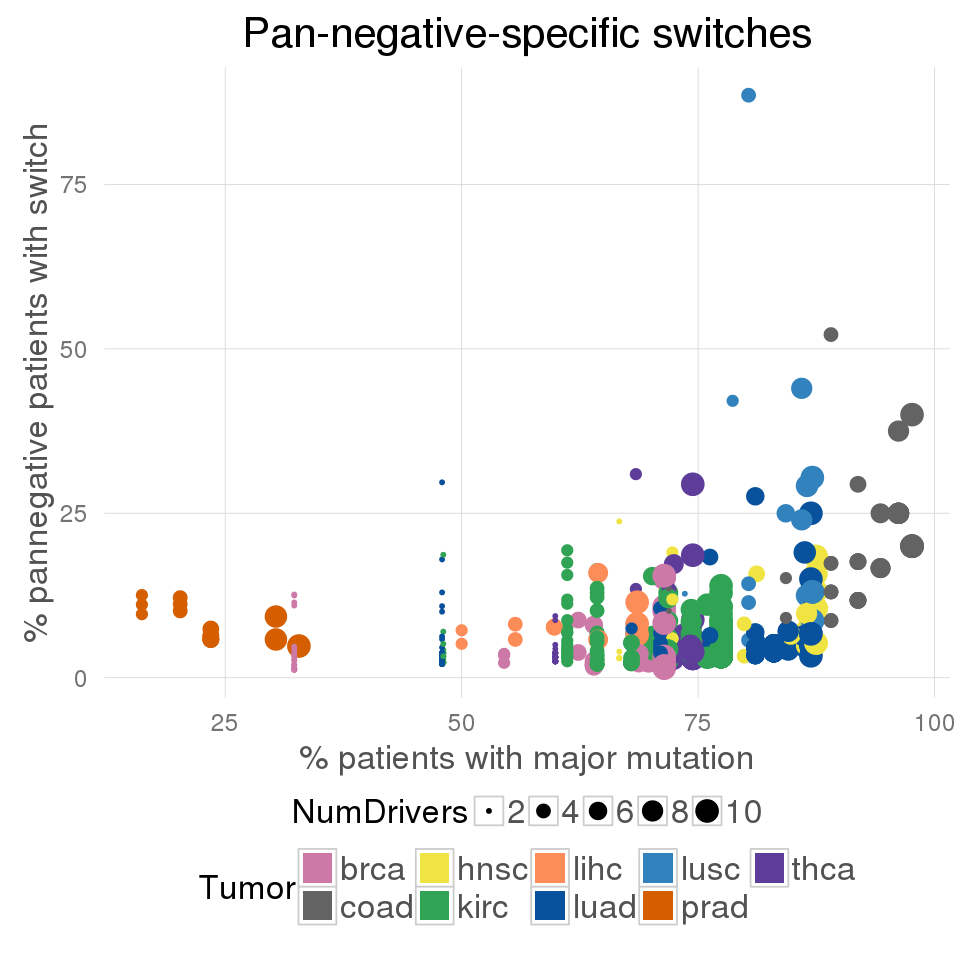

In [3]:
potus.pn <- merge(candidates,subset(me,p.me<0.05))
#write_tsv(potus.pn, "results/potus.pannegative.tsv")

df <- by(potus.pn, paste0(potus.pn$GeneId,potus.pn$Tumor), 
         function(X) X[which.max(X$NumDrivers),]) %>%
      do.call("rbind",.)

ggplot(df,aes(x=(M.p+MS.p)*100,y=(S/(N+S))*100,color=Tumor)) + 
  geom_point(aes(size=NumDrivers)) + 
  #geom_text_repel(aes(label=Symbol)) +
  smartas_theme() +
  scale_color_manual(values=colorPalette) +
  labs(x="% patients with major mutation", y="% pannegative patients with switch",title="Pan-negative-specific switches") +
  theme(legend.position="bottom") +
  guides(col = guide_legend(override.aes = list(shape = 15, size = 8)))

The previous plot misses one dimension: the overlap between switches and mutations.

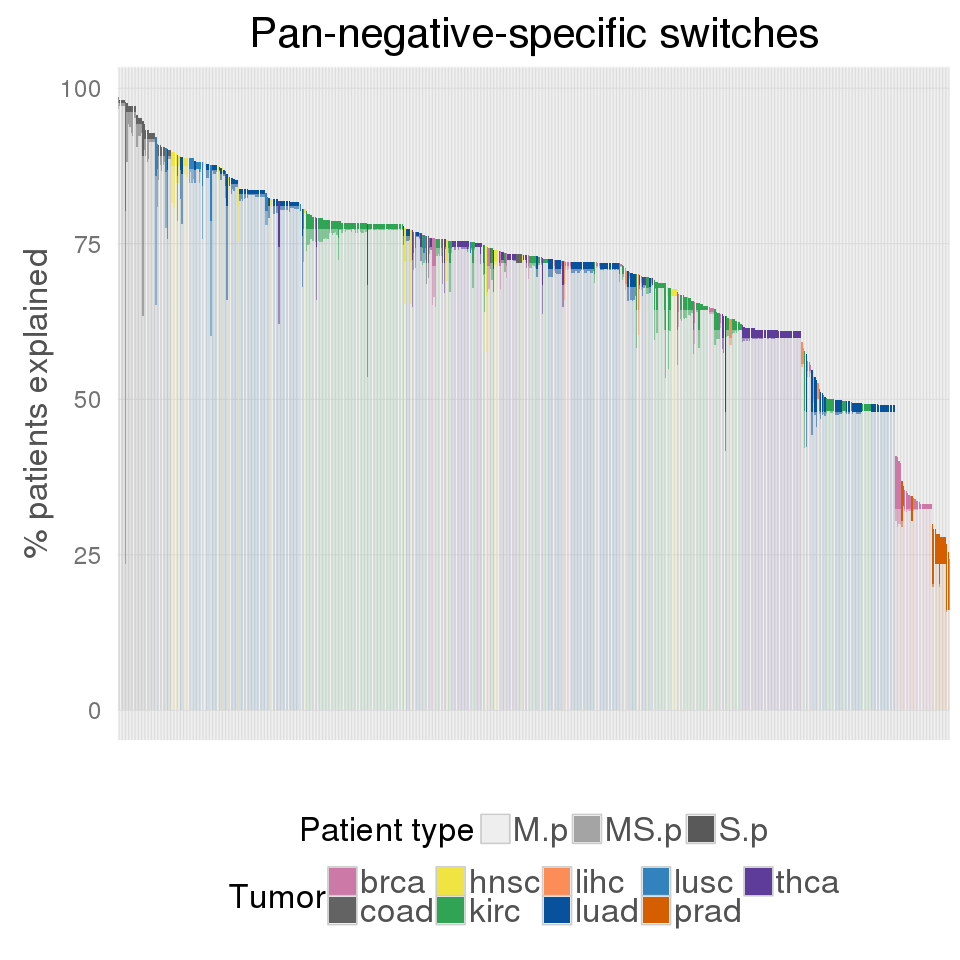

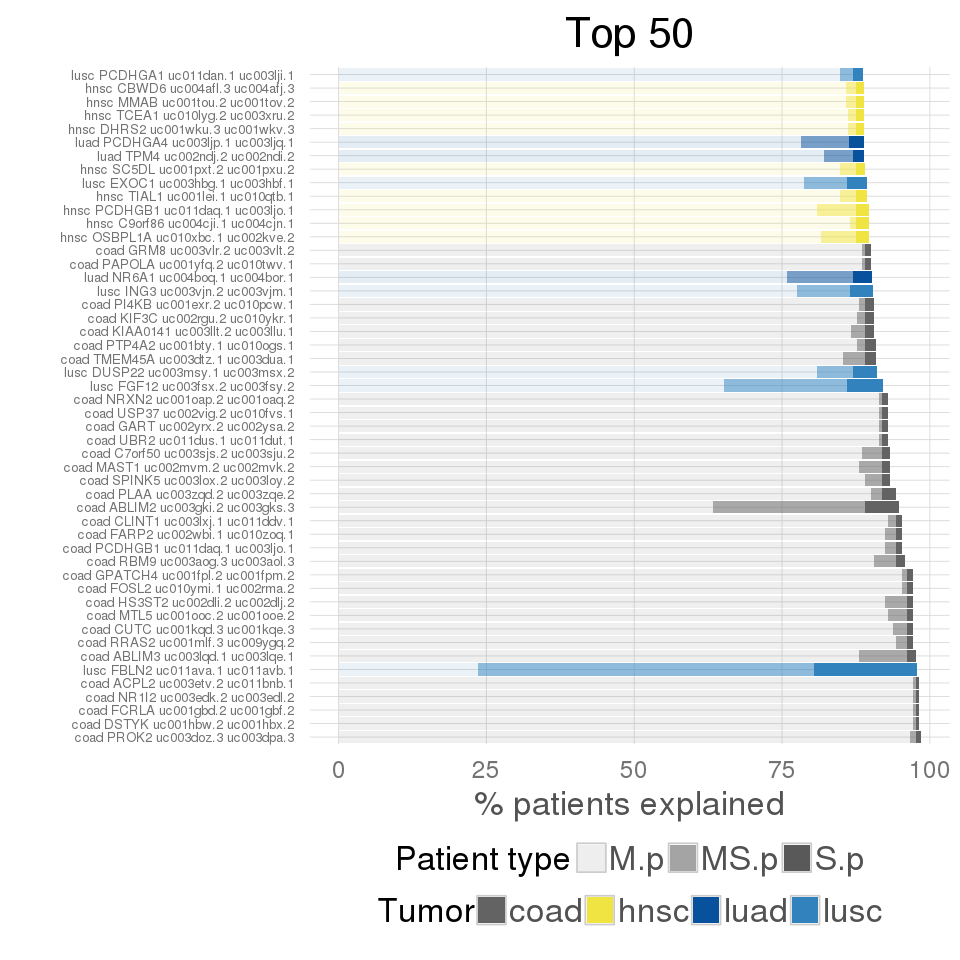

In [4]:
# prepare data
## order genes by total number of patients explained
df2 <- df %>%
    select(Tumor,GeneId,Symbol,Normal_transcript,Tumor_transcript,MS.p,M.p,S.p) %>%
    mutate(Switch = as.character(paste(Tumor,Symbol,Normal_transcript,Tumor_transcript))) %>%
    arrange(-(MS.p+M.p+S.p)) %>%
    mutate(Switch = factor(Switch,levels=Switch)) %>%
    select(Tumor,Switch,M.p,MS.p,S.p)

# overview of cases
melt(df2, id.vars=c('Tumor','Switch')) %>%
    mutate(variable = factor(variable,levels=c("M.p","MS.p","S.p"))) %>%
    ggplot(aes(x=Switch,y=value*100, alpha=variable, fill=Tumor)) +
        geom_bar(stat="identity") +
        labs(x="", y="% patients explained", alpha="Patient type",title="Pan-negative-specific switches") +
        scale_fill_manual(values=colorPalette) +
        smartas_theme() +
        theme(axis.text.x=element_blank()) +
        theme(legend.position="bottom")

# show in detail the cases where more patients are explained
melt(df2[1:50,], id.vars=c('Tumor','Switch')) %>%
    mutate(variable = factor(variable,levels=c("M.p","MS.p","S.p"))) %>%
    ggplot(aes(x=Switch,y=value*100, alpha=variable, fill=Tumor)) +
        geom_bar(stat="identity") +
        labs(x="", y="% patients explained", alpha="Patient type",title="Top 50") +
        scale_fill_manual(values=colorPalette) +
        smartas_theme() +
        theme(legend.position="bottom", axis.text.y=element_text(size=8)) +
        coord_flip()

## Mutational drivers

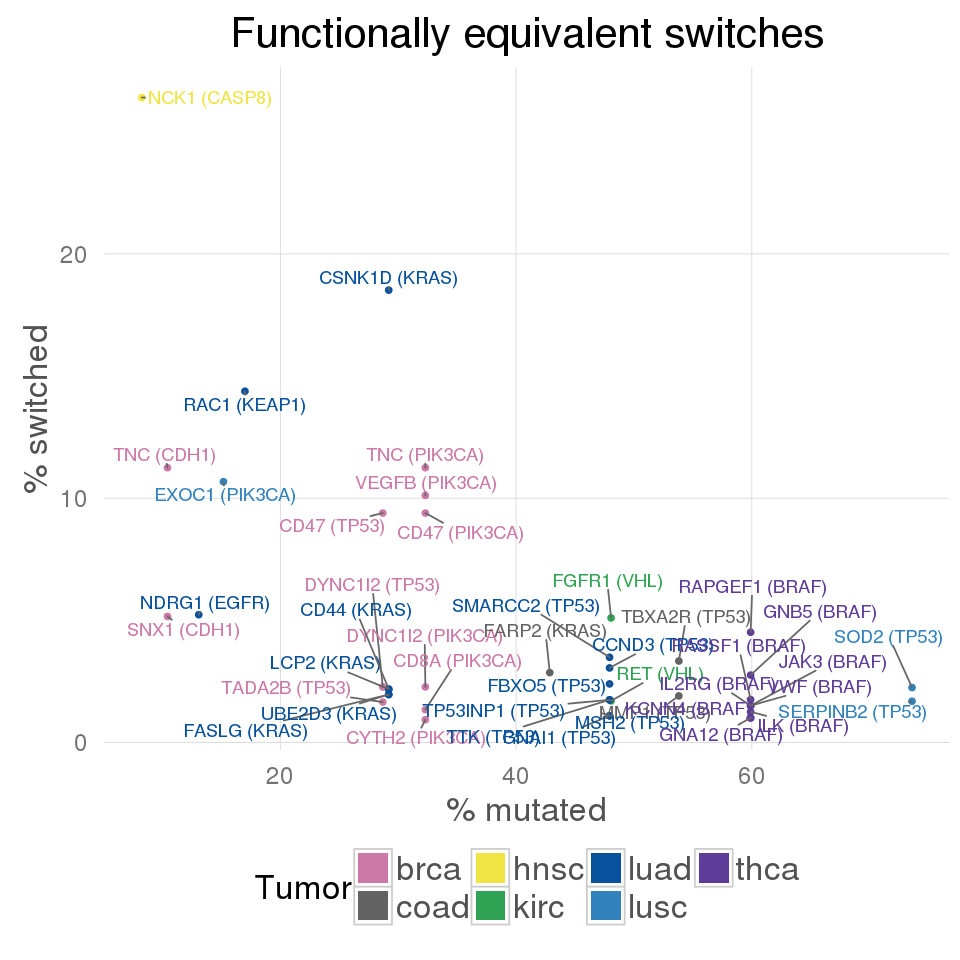

In [5]:
potus.d <- me.specificDrivers %>%
    filter(p.me < 0.05 & Distance>0 & Pathway!="") %>%
    merge(candidates,by=c("Tumor","GeneId","Symbol","Normal_transcript","Tumor_transcript"))

write_tsv(potus.d, "results/potus.meDrivers.tsv")

ggplot(potus.d,aes(x=(MS.p+M.p)*100,y=(MS.p+S.p)*100,color=Tumor)) + 
    geom_point() +
    geom_text_repel(aes(label=paste0(Symbol," (",DriverSymbol,")"))) +
    labs(x="% mutated", y="% switched", title="Functionally equivalent switches") +
    scale_color_manual(values=colorPalette) +
    smartas_theme() +
    theme(legend.position="bottom") +
    guides(col = guide_legend(override.aes = list(shape = 15, size = 8)))

## Summary

In [6]:
pn <- as.data.frame(table(unique(potus.pn[,c("Tumor","GeneId","Normal_transcript","Tumor_transcript")])$Tumor))
colnames(pn) <- c("Tumor","Pan-negative")
d <- as.data.frame(table(unique(potus.d[,c("Tumor","GeneId","Normal_transcript","Tumor_transcript")])$Tumor))
colnames(d) <- c("Tumor","Equivalent")

df <- merge(pn,d,all=T)
df

,Tumor,Pan-negative,Equivalent
1,brca,53,8
2,coad,44,3
3,hnsc,33,1
4,kirc,164,2
5,lihc,11,NA
6,luad,148,14
7,lusc,21,3
8,prad,16,NA
9,thca,85,9


In [7]:
potus <- unique(rbind(
  potus.d[,c("Tumor","GeneId","Symbol","Normal_transcript","Tumor_transcript")],
  potus.pn[,c("Tumor","GeneId","Symbol","Normal_transcript","Tumor_transcript")]))

nrow(unique(potus[,c("GeneId","Symbol","Normal_transcript","Tumor_transcript")]))

write_tsv(potus, "results/potus.tsv")

[1] 544

# Tumor affectation

In [ ]:
alterations <- list()
for (cancer in cancerTypes){
  
  # correct tag according to Intogen nomenclature
  if (cancer=="coad"){
    tag="COREAD"
  } 
#     else if  (cancer=="kich") {
#     next
#   } else if (cancer=="kirp") {
#     next
#   } 
    else if (cancer=="kirc") {
    tag <- "RCCC"
  } else if (cancer=="lihc") {
    tag <- "HC"
  } else {
    tag <- toupper(cancer)
  }
  
  # read switches
  this.switches <- subset(switches, Tumor==cancer)
  this.switches <- merge(this.switches,potus)
  
  ## count number of AS drivers switched per patient
  switchesPerPatient <- table(unlist(strsplit(as.character(this.switches$Patients_affected),",")))
  
  # get sample names
  psi.nt.file <- paste0("/projects_rg/TCGA/pipeline/run11/",cancer,"_iso_psi_paired-filtered.txt")
  psi.t.file <- paste0("/projects_rg/TCGA/pipeline/run11/",cancer,"_iso_psi_tumor-filtered.txt")
  
  patients.nt <- readLines(psi.nt.file, n=1)
  patients.nt <- unlist(strsplit(patients.nt,"\t"))
  patients.t <- readLines(psi.t.file, n=1)
  patients.t <- unlist(strsplit(patients.t,"\t"))
  
  patients <- c(patients.nt,patients.t)
  tumor <- grep("^.{4}T$",patients, value=TRUE)
  
  # read mutations  
  ## get cancer specific drivers
  this.drivers <- drivers[drivers$Tumor_type==tag,]
  
  ## read mutations
  mutations.file <- paste0("~/smartas/data/ucsc/rawdata/",cancer,"_gene_mutation-functional-count_full.txt")
  mutations <- read.delim(mutations.file,header=F) %>%
    set_colnames(c("chr","start","end","gene","wut1","wut2","wut3","wut4","wut5","alteration","wut6","wut7")) %>%
    filter(alteration != ".") %>%
    mutate(., Symbol = unlist(strsplit(as.character(.$gene),"|",fixed=T))[c(T,F)],
           Patient = unlist(strsplit(as.character(.$alteration),";"))[c(T,F)])
  
  ## filter out mutations not in drivers
  mutations.drivers <- mutations %>%
    filter(Symbol %in% this.drivers$geneHGNCsymbol)
  
  ## consider only mutated genes, not several mutations in a gene
  mutations.drivers <- unique(mutations.drivers[,c("gene","Patient")])
  
  ## count number of mutations per patient
  mutationsPerPatient <- table(mutations.drivers$Patient)
  
  # get patients common between paired patients screened for switches, 
  # patients screened for mutations
  patients.mut <- unique(mutations$Patient)
  patients.common <- intersect(tumor,patients.mut)
  
  ## filter out those patients without full information
  switchesPerPatient <- switchesPerPatient[patients.common]
  names(switchesPerPatient) <- patients.common
  switchesPerPatient[is.na(switchesPerPatient)] <- 0
  switchesPerPatient <- switchesPerPatient/nrow(this.switches)
  
  mutationsPerPatient <- mutationsPerPatient[patients.common]
  names(mutationsPerPatient) <- patients.common
  mutationsPerPatient[is.na(mutationsPerPatient)] <- 0
  mutationsPerPatient <- mutationsPerPatient/nrow(this.drivers)
  
  # merge lists
  alterations[[cancer]] <- t(rbind.fill.matrix(t(switchesPerPatient), t(mutationsPerPatient))) %>%
    as.data.frame %>%
    set_colnames(c("Switches","Mutations")) %>%
    mutate(Tumor = cancer)
  
}

alterationsPerPatient <- do.call("rbind",alterations) %>%
    mutate(Switches = ifelse(is.na(Switches), 0, Switches),
           Mutations = ifelse(is.na(Mutations), 0, Mutations))

In [ ]:
# plot raw frequency
ggplot(alterationsPerPatient,aes(x=Switches*100,y=Mutations*100,color=Tumor)) + 
  geom_point(size=5) + 
  smartas_theme() +
  labs(x="% splicing drivers switched",y="% mutational drivers mutated", title="Tumor mechanism per patient") +
  scale_color_manual(values=colorPalette) +
  theme(legend.position="bottom")

# plot 2d density
rf <- colorRampPalette(rev(brewer.pal(11,'Spectral')))
ggplot(alterationsPerPatient,aes(x=Switches*100,y=Mutations*100)) + 
  stat_binhex() +
  smartas_theme() +
  labs(x="% splicing drivers switched",y="% mutational drivers mutated", title="Tumor mechanism per patient (density)") +
  theme(legend.position="bottom")

In [ ]:
alterationsPerPatient$Class <- "M"
alterationsPerPatient$Class[alterationsPerPatient$Mutations < alterationsPerPatient$Switches] <- "S"

df <- alterationsPerPatient %>%
    select(Class,Tumor) %>%
    table %>%
    as.data.frame %>%
    set_colnames(c("Class","Tumor","Counts"))

total <- alterationsPerPatient$Tumor %>%
    table %>% 
    as.data.frame %>%
    set_colnames(c("Tumor","Patients"))

df <- merge(df,total) %>%
    mutate(Prop = Counts/Patients,
           Tumor = factor(Tumor, levels=Tumor[Class=="M"][order(Prop[Class=="M"])]),
           Class = factor(Class, levels=c("S","M")))

ggplot() + 
    geom_bar(data=subset(df, Class=="M"),aes(x=Tumor,y=-Prop*100,fill=Tumor),stat="identity",alpha=0.5,) +
    geom_bar(data=subset(df, Class=="S"),aes(x=Tumor,y=Prop*100,fill=Tumor),stat="identity") +
    geom_rect(data = subset(df, Class=="M"), aes(xmin=0.5, xmax=11.5, ymin=0, ymax=100), fill = "green", alpha = 0.01) +
    geom_rect(data = subset(df, Class=="S"), aes(xmin=0.5, xmax=11.5, ymin=0, ymax=-100), fill = "red", alpha = 0.01) +
    geom_text(aes(x=8,y=85,label="Switches"),size=10) +
    geom_text(aes(x=2,y=-85,label="Mutations"),size=10) +
    scale_fill_manual(values=colorPalette) +
    labs(y="",title="Leading mechanism") +
    scale_y_continuous(limits = c(-100,100)) +
    smartas_theme()

Check suspicious cases eg PRAD: it seems mutational, but there are patients with lots of switches.